## 1. Lineare Regression

In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import matplotlib
if matplotlib.__version__=='3.7.0':
    print("""
Matplotlib Verison 3.7.0 von Feb. 2023 hat mehrere Bugs.
Einer von ihnen verhindert Aufrufe der Art "ax.set_xlim(\'2014-04-01\',...)"
Behelfslösungen:
Entsprechende Aufrufe auskommentieren oder
über "pip3 install matplotlib==3.6.3" die Vorgängerversion installieren.
""")

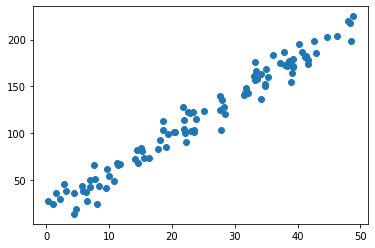

In [2]:
# Create demo data

ndat = 100
rng = np.random.default_rng(42)
rng2 = np.random.default_rng(43)


def my_lin(x, m=4, b=20, e=0):
    return m * x + b + e
    
x = rng.random(ndat)*50
e = rng2.normal(0,10,len(x))
y = my_lin(x, e=e)


plt.scatter(x,y)
plt.show()

In [3]:
# linear regression demo

a = scipy.stats.linregress(x,y)

print(f'y = {a.slope:.2g}x + {a.intercept:.3g}')

y = 4.1x + 16.8


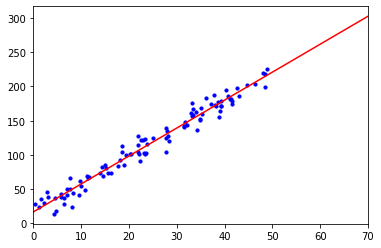

In [4]:
plt.scatter(x,y, color='blue', s=10)

extrapol=70
line_points = [0,extrapol]
plt.plot(line_points, my_lin(np.array(line_points), m=a.slope, b=a.intercept),
        color='red')
plt.xlim(0,extrapol)
plt.show()


## 2. Temperaturvorhersage

Quelle: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities

In [5]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities
fn = 'data/city_temperature.zip'

df = pd.read_csv(fn, compression='zip', low_memory=False) #dtype={'State':object})
                    
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 767.7 MB


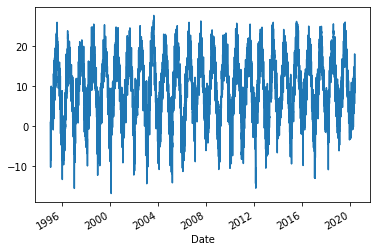

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9850 entries, 1995-01-01 to 2020-05-13
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AvgTemperature  9850 non-null   float64
dtypes: float64(1)
memory usage: 153.9 KB
None


,AvgTemperature
Date,
1995-01-01,0.944444
1995-01-02,-1.611111
1995-01-03,-3.555556
1995-01-04,-9.833333
1995-01-05,-10.222222


In [6]:
df = df[df['City']=='Munich']
df = df[['Year', 'Month', 'Day', 'AvgTemperature']]


df = df[df['AvgTemperature']>-70]

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) 
df = df.set_index(df['Date'])
df = df[['AvgTemperature']]

df['AvgTemperature'] = (df['AvgTemperature']-32)*5/9

df['AvgTemperature'].plot()
plt.show()

print(df.info(memory_usage="deep"))
df.head()

In [7]:
dg = df.copy()

resamp = 'D'
dg = dg.resample(resamp).mean()
print('Missing: ', resamp, ': ', int(dg.loc[:, :].isnull().sum()) )

resamp = '2W'
dg = dg.resample(resamp).mean()
print('Missing: ', resamp, ': ', int(dg.loc[:, :].isnull().sum()) )

Missing:  D :  72
Missing:  2W :  1


In [8]:
dg = dg.interpolate(method='linear')
print('Missing: ', resamp, ': ', int(dg.loc[:, :].isnull().sum()) )

Missing:  2W :  0


<AxesSubplot: xlabel='Date'>

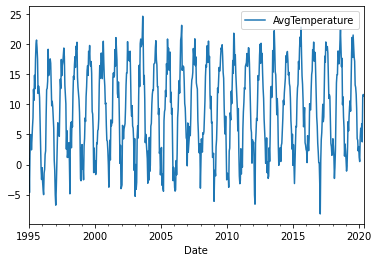

In [9]:
dg.plot()

### Holt-Winters Exponentielle Glättung

#### Vorbereiten der dreifachen exponentiellen Glättung

In [10]:


dh = dg.copy()

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=False,
                           seasonal_periods=26)

#### Vorgabe der Variablen alpha, beta und Tamma

In [11]:
dmodel = model.fit(
    smoothing_level = 0.1,
    smoothing_trend = 0.5,
    smoothing_seasonal = 0.1,
    optimized=False
    )

dhfc = pd.DataFrame(dmodel.forecast(60), columns=['forecast'])
dhfc['forecast'] = sc.inverse_transform([dhfc.loc[:,'forecast'].tolist()])[0,:]
dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]

hw_param = f"({dmodel.params['smoothing_level']:.2g}, \
{dmodel.params['smoothing_trend']:.2g}, {dmodel.params['smoothing_seasonal']:.2g})"

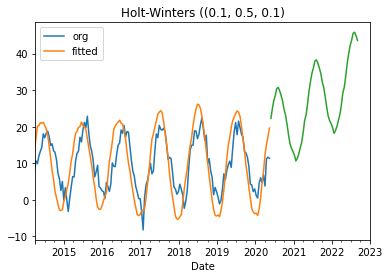

None
---
{'smoothing_level': 0.1, 'smoothing_trend': 0.5, 'smoothing_seasonal': 0.1, 'damping_trend': nan, 'initial_level': 0.5248976555268727, 'initial_trend': -0.004727013854325267, 'initial_seasons': array([-0.26926465, -0.27734464, -0.32197579, -0.33557927, -0.20622555,
       -0.13339995, -0.14630874, -0.08052457, -0.05852629,  0.08138289,
        0.15507437,  0.16887168,  0.26996105,  0.23763939,  0.2601973 ,
        0.30446072,  0.30709146,  0.30655289,  0.18205556,  0.11545019,
        0.09699322,  0.05997541, -0.05531926, -0.10656559, -0.26611508,
       -0.28855675]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
---
                     name     param  optimized
smoothing_level     alpha  0.100000      False
smoothing_trend      beta  0.500000      False
smoothing_seasonal  gamma  0.100000      False
initial_level         l.0  0.524898      False
initial_trend         b.0 -0.004727      False
initial_seasons.0     s.0 -0.269265      False
initial_seasons.1     s.

Dep. Variable:,scal,No. Observations:,663
Model:,ExponentialSmoothing,SSE,10.998
Optimized:,False,AIC,-2657.672
Trend:,Additive,BIC,-2522.769
Seasonal:,Additive,AICC,-2654.320
Seasonal Periods:,26,Date:,"Sun, 19 Feb 2023"
Box-Cox:,False,Time:,14:13:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
smoothing_trend,0.5000000,beta,False


In [12]:
fig, ax = plt.subplots()
dh['AvgTemperature'].plot(ax=ax)
dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)
ax.legend(['org', 'fitted'])
ax.set_xlim('2014-04-01','2022-12-30')
plt.title('Holt-Winters ('+ hw_param )
plt.show()

print(dmodel.mle_retvals)
print('-'*3)
print(dmodel.params)
print('-'*3)
print(dmodel.params_formatted)
dmodel.summary()

#### Fit

In [13]:
model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=False,
                           seasonal_periods=26)

dmodel = model.fit()
dhfc = pd.DataFrame(dmodel.forecast(60), columns=['forecast'])
dhfc['forecast'] = sc.inverse_transform([dhfc.loc[:,'forecast'].tolist()])[0,:]
dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]

hw_param = f"({dmodel.params['smoothing_level']:.2g}, \
{dmodel.params['smoothing_trend']:.2g}, {dmodel.params['smoothing_seasonal']:.2g})"

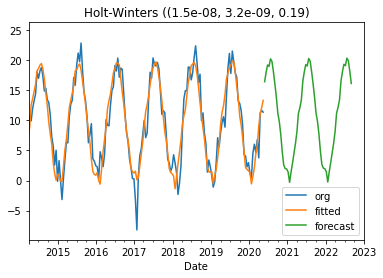

     fun: 3.7658687971153837
     jac: array([ 1.38915089e+00,  0.00000000e+00,  8.52942467e-05,  1.02072954e-03,
        1.04431993e+00, -3.95178795e-05,  9.77516174e-05, -5.30183315e-05,
        2.97427177e-05,  5.66840172e-05, -5.51342964e-05,  7.74860382e-05,
        1.05917454e-04,  3.51965427e-05, -9.50694084e-06,  1.66445971e-04,
        8.46087933e-05,  8.02576542e-05,  1.17719173e-04,  6.84857368e-05,
       -1.25646591e-04,  4.05013561e-05,  5.00679016e-06,  1.51932240e-04,
        6.53564930e-05, -3.96966934e-05, -8.16881657e-05,  2.36034393e-05,
        2.68220901e-05,  1.11758709e-05,  1.80602074e-04])
 message: 'Optimization terminated successfully'
    nfev: 691
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 1.49011612e-08,  3.15410677e-09,  1.85178957e-01,  5.10344696e-01,
        6.71230198e-05, -2.73159012e-01, -3.16817551e-01, -3.09738829e-01,
       -2.79631514e-01, -1.99370783e-01, -1.95201526e-01, -1.53576935e-01,
       -9.71221877e-02, -5

Dep. Variable:,scal,No. Observations:,663
Model:,ExponentialSmoothing,SSE,3.766
Optimized:,True,AIC,-3368.238
Trend:,Additive,BIC,-3233.335
Seasonal:,Additive,AICC,-3364.886
Seasonal Periods:,26,Date:,"Sun, 19 Feb 2023"
Box-Cox:,False,Time:,14:13:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.1541e-09,beta,True


In [14]:
fig, ax = plt.subplots()
dh['AvgTemperature'].plot(ax=ax)
dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)
ax.legend(['org', 'fitted', 'forecast'])
ax.set_xlim('2014-04-01','2022-12-30')
plt.title('Holt-Winters ('+ hw_param )
plt.show()

print(dmodel.mle_retvals)
print('-'*3)
print(dmodel.params)
print('-'*3)
print(dmodel.params_formatted)
dmodel.summary()

## 3. Milchproduktion

Quellen:

Quellen: Milk availability, usage and production dataset: https://www.gov.uk/government/statistics/milk-utilisation-by-dairies-in-england-and-wales

Datendatei: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1121068/milkutil-dataset-01dec22.ods]


### Laden der Daten

In [15]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1121068/milkutil-dataset-01dec22.ods'
#!wget $url

fn = Path(url).name
print(fn)
fn2 = Path(url).stem + ".csv"
print(fn2)

## Libreoffice may have different names:
#!libreoffice --headless --convert-to csv $fn
#!soffice --headless --convert-to csv $fn
#!libreoffice7.4 --headless --convert-to csv $fn

## perheaps this is libraries are needed as well (Linux):
#!sudo apt-get install default-jre libreoffice-java-common

#!mv $fn2 data/$fn2

milkutil-dataset-01dec22.ods
milkutil-dataset-01dec22.csv


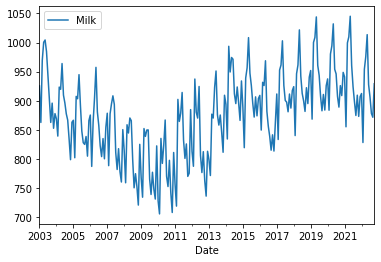

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238 entries, 2003-01-31 to 2022-10-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Milk    238 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


In [16]:
fn = 'data/milkutil-dataset-01dec22.csv'
#fn = 'data/t1.csv'

# skip 8 lines
# superscript numbers in column 2
# engine='python': required for: skipfooter=10
# rename header: names = ['Date', 'Milk'], header = 0,

df = pd.read_csv(fn, usecols=[0,5], parse_dates=['Date'], index_col='Date', 
        names = ['Date', 'Milk'], header = 0,
        skiprows=8, encoding = "ISO-8859-1", engine='python', skipfooter=9)

df = df.resample('M').mean()

df.plot()
plt.show()

df.info()

### Datenfit und -vorhersage

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

dh = df.copy()

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)

dmodel = model.fit()

dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]
dhfc = pd.DataFrame(dmodel.forecast(36))
dhfc['forecast'] = sc.inverse_transform([dhfc.iloc[:,0].tolist()])[0,:]

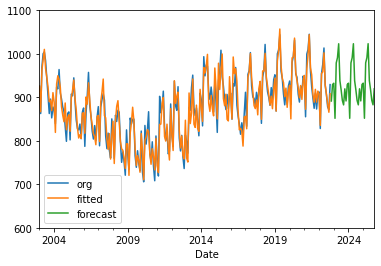

Dep. Variable:,scal,No. Observations:,238
Model:,ExponentialSmoothing,SSE,0.980
Optimized:,True,AIC,-1275.276
Trend:,Additive,BIC,-1219.720
Seasonal:,Additive,AICC,-1272.153
Seasonal Periods:,12,Date:,"Sun, 19 Feb 2023"
Box-Cox:,True,Time:,14:13:14
Box-Cox Coeff.:,0.91471,,
,coeff,code,optimized
smoothing_level,0.5363081,alpha,True
smoothing_trend,0.000000,beta,True


In [18]:
fig, ax = plt.subplots()
dh['Milk'].plot(ax=ax)

dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)

ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(600,1100)
plt.show()

dmodel.summary()

### Vorhersage zu anderen Zeitpunkten

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

dh = df.copy()
dh = dh.loc[:'2011-12',:] 

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)

dmodel = model.fit()

dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]
dhfc = pd.DataFrame(dmodel.forecast(36))
dhfc['forecast'] = sc.inverse_transform([dhfc.iloc[:,0].tolist()])[0,:]

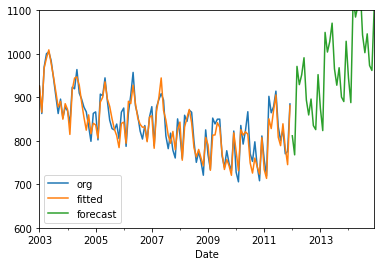

Dep. Variable:,scal,No. Observations:,108
Model:,ExponentialSmoothing,SSE,0.519
Optimized:,True,AIC,-544.536
Trend:,Additive,BIC,-501.622
Seasonal:,Additive,AICC,-536.851
Seasonal Periods:,12,Date:,"Sun, 19 Feb 2023"
Box-Cox:,True,Time:,14:13:14
Box-Cox Coeff.:,0.72735,,
,coeff,code,optimized
smoothing_level,0.1600281,alpha,True
smoothing_trend,0.1600281,beta,True


In [20]:
fig, ax = plt.subplots()
dh['Milk'].plot(ax=ax)

dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)

ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(600,1100)
plt.show()

dmodel.summary()

## Solare Energie

Quelle: https://www.energy-charts.info/charts/energy/chart.htm?l=en&c=DE&chartColumnSorting=default&year=-1&month=-1&stacking=stacked_absolute&timeslider=1 , 
dort auswählen *export* und *csv*


In [21]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing

Laden und Anschauen der Daten

In [22]:
fn = 'data/energy-charts_Total_net_electricity_generation_in_Germany.csv'

df = pd.read_csv(fn)
df.tail()

,Month,Nuclear,Hydro Run-of-River,Biomass,Fossil brown coal / lignite,Fossil coal-derived gas,Fossil hard coal,Fossil oil,Fossil gas,Geothermal,Hydro water reservoir,Others,Waste renewable,Waste non-renewable,Wind offshore,Wind onshore,Solar
91,8.2022,2941.3,1339.6,3385.3,9288.9,0.0,5552.4,14.4,7390.1,12.4,92.2,494.5,326.4,353.5,1015.1,3437.6,7662.8
92,9.2022,2893.2,1297.0,3374.4,9093.6,0.0,6016.7,12.2,5779.9,13.9,100.8,423.9,343.1,371.6,1916.1,6056.9,5048.5
93,10.2022,2665.8,1411.7,3635.2,9061.7,0.0,3669.4,14.0,7173.7,14.2,104.2,383.3,361.8,391.8,2460.8,8312.9,3743.7
94,11.2022,2836.8,1165.0,3701.3,9658.6,0.0,5931.1,39.6,6936.2,13.5,76.4,560.3,334.0,361.7,2814.0,9813.5,1791.9
95,12.2022,307.6,123.5,423.7,1199.0,0.0,1127.6,10.2,1664.8,1.6,7.0,91.4,41.9,45.4,329.9,486.8,41.6


Anpassen des ungewöhnlichen Datums-Formats; Beschränkung auf Spalte *Solar*

Missing for resampling period  M :  0


,Solar
Date,
2015-01-31,621.4
2015-02-28,1522.2
2015-03-31,3173.8
2015-04-30,4924.5
2015-05-31,4898.1


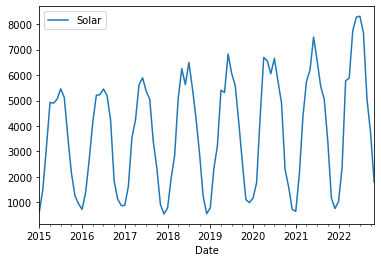

In [23]:
my_date_parser = lambda x: datetime.strptime(x, "%m.%Y")

df = pd.read_csv(fn, index_col='Month', usecols=['Month', 'Solar'],
                 parse_dates=['Month'], date_parser =  my_date_parser)
df.index.name='Date'

#drop last value (incomplete information about last month)
df = df.iloc[:-1,:]
resamp = 'M'
df = df.resample(resamp).mean()
print('Missing for resampling period ', resamp, ': ', int(df.loc[:, :].isnull().sum()) )

display(df.head())

df.plot()
plt.show()

### Additiver/multiplikativer Trend

In [24]:
dh = df.copy()

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

#model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=True,
#                           seasonal_periods=12)
#dmodel = model.fit() #method = 'ls')

model = ExponentialSmoothing(dh['scal'], trend='mul',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)# , damped_trend=True)
dmodel = model.fit(method = 'ls')


dhfc = pd.DataFrame(dmodel.forecast(36), columns=['forecast'])
dhfc['forecast'] = sc.inverse_transform([dhfc.iloc[:,0].tolist()])[0,:]
dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]

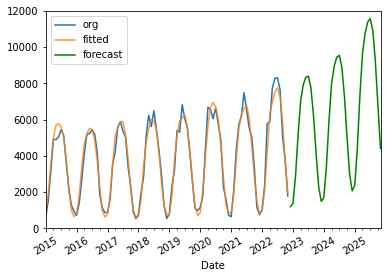

Dep. Variable:,scal,No. Observations:,95
Model:,ExponentialSmoothing,SSE,0.313
Optimized:,True,AIC,-510.955
Trend:,Multiplicative,BIC,-470.093
Seasonal:,Additive,AICC,-501.955
Seasonal Periods:,12,Date:,"Sun, 19 Feb 2023"
Box-Cox:,True,Time:,14:13:16
Box-Cox Coeff.:,0.54006,,
,coeff,code,optimized
smoothing_level,0.2675896,alpha,True
smoothing_trend,0.0006598,beta,True


In [25]:
fig, ax = plt.subplots()
dh['Solar'].plot(ax=ax)
dh['fitted'].plot(ax=ax, alpha=0.8)
dhfc['forecast'].plot(ax=ax, color='green')
ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(0,12000)
plt.xticks(rotation=30)
plt.show()

dmodel.summary()